Projet Séries Chronologiques : Ventes d'une boutique

Données : Ensemble de données de vente au détail d'un supermarché mondial pendant 4 ans. (Kaggle)

Importation des packages

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display
import torch
from jyquickhelper import add_notebook_menu
add_notebook_menu()
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = 18,8
pd.set_option('display.max_columns', None)


from sklearn.metrics import mean_squared_error


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm


Récupérons les données

In [47]:
df = pd.read_csv('data/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

On souhaite représenter seulement les ventes au fil du temps.

In [48]:

df = df[['Order Date','Sales']]
df.rename(columns={'Order Date' : 'Date'},inplace = True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(df.Date,inplace = True)
df.drop('Date',axis=1,inplace = True)
display(df)



,Sales
Date,
2017-08-11,261.9600
2017-08-11,731.9400
2017-12-06,14.6200
2016-11-10,957.5775
2016-11-10,22.3680
...,...
2017-05-21,3.7980
2016-12-01,10.3680
2016-12-01,235.1880


On retrouve 9800 observations.

Vérifions si nous avons des données manquantes dans notre série temporelle, si c'est le cas notre série temporelle ne fonctionnera pas.

In [49]:
df.isna().sum()

Sales    0
dtype: int64

Il n'y a pas de données manquantes.

In [50]:
df.describe()


,Sales
count,9800.000000
mean,230.769059
std,626.651875
min,0.444000
25%,17.248000
50%,54.490000
75%,210.605000
max,22638.480000


On constate que les ventes possèdent des valeurs aberrantes.

Comme les données sont collectées pour chaque commande, on calcule la moyenne des commandes par mois.

In [51]:

df = df.resample('M').mean()
display(df)

,Sales
Date,
2015-01-31,228.795667
2015-02-28,149.862905
2015-03-31,335.575727
2015-04-30,204.215008
2015-05-31,202.195137
2015-06-30,216.158034
2015-07-31,228.536091
2015-08-31,257.581141
2015-09-30,277.127730


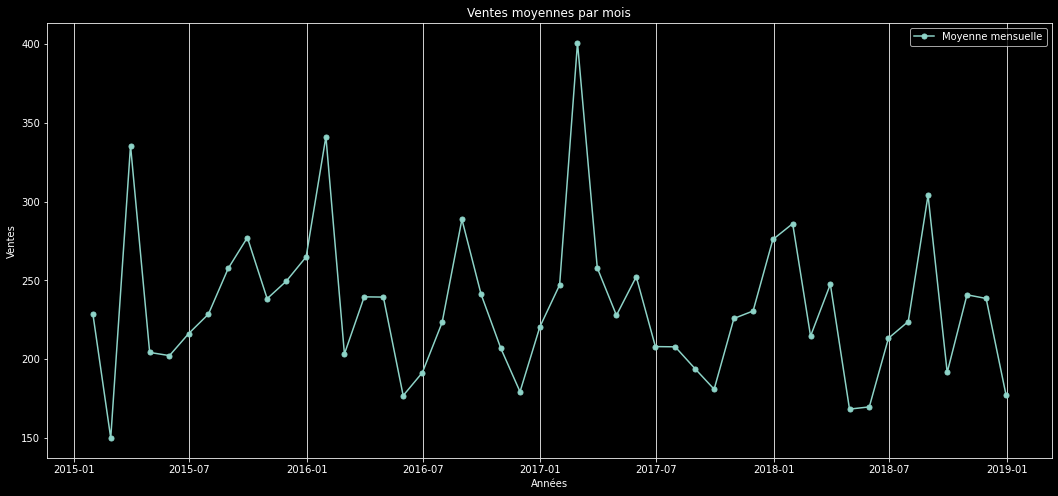

In [52]:
y = df['Sales']
fig,ax = plt.subplots(figsize = (18,8))
ax.plot(y,marker = 'o',markersize='5',linestyle='-',label = 'Moyenne mensuelle')
ax.set_xlabel('Années')
ax.set_ylabel('Ventes')
ax.set_title('Ventes moyennes par mois')
ax.grid(axis='x')
ax.legend();

On considère que l'on a une série temporelle suivant un modèle additif.

Afin d'avoir un aperçu plus complet de notre série temporelle, nous allons la série de façon à avoir :
-Observations (série actuelle)
-Tendance
-Saisonalité
-Résidus

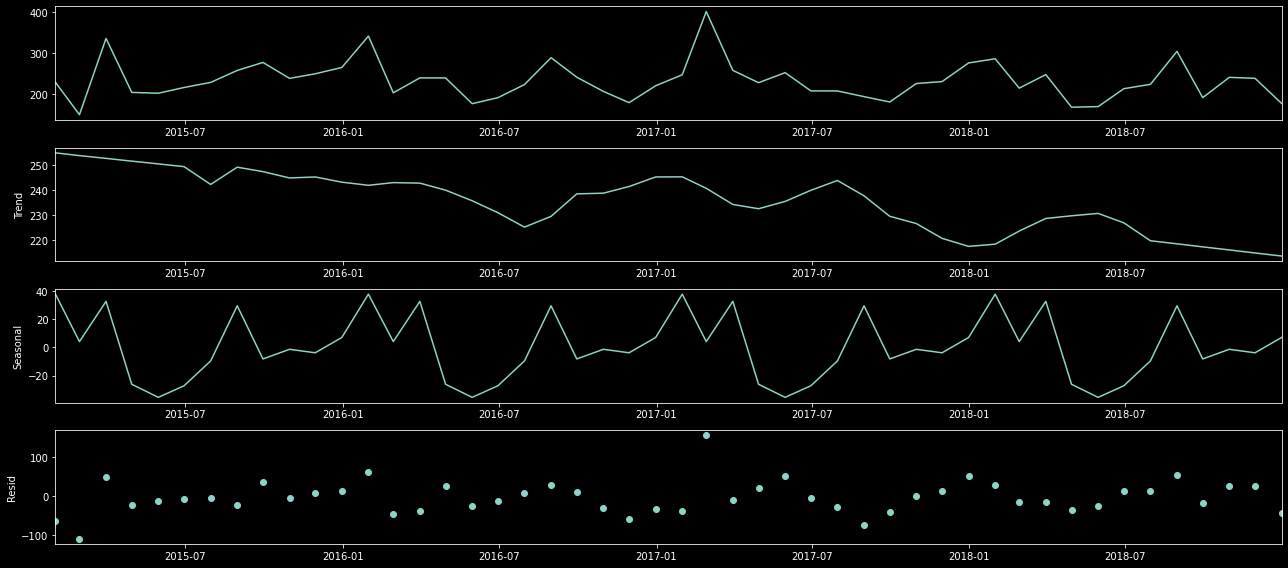

In [53]:
df_dec=seasonal_decompose(df,model='additive', extrapolate_trend='freq')
df_dec.plot();

On voit que notre série à une tendance descendante et qu'il y a bien une saisonalité.
C'est pourquoi, on pourra utiliser cette série temporelle afin de prédire les futures observations.


Stationnarité

Maintenant, nous devons vérifier si la série est stationnaire. C'est le cas si :
-La moyenne est constante
-La variance est constante

Si ce n'est pas le cas, nous devons rendre la série stationnaire afin d'utiliser des modèles prédictifs sur cette série.

Nous allons utiliser deux méthodes afin de vérifier la stationnarité :
-Visualisation graphique
-Test augmenté de Dickey-Fuller (Test ADF)

Visualisation

In [58]:
sales_mean = df.Sales.rolling(100).mean()
sales_std = df.Sales.rolling(100).std()

Rolling [window=100,center=False,axis=0,method=single]

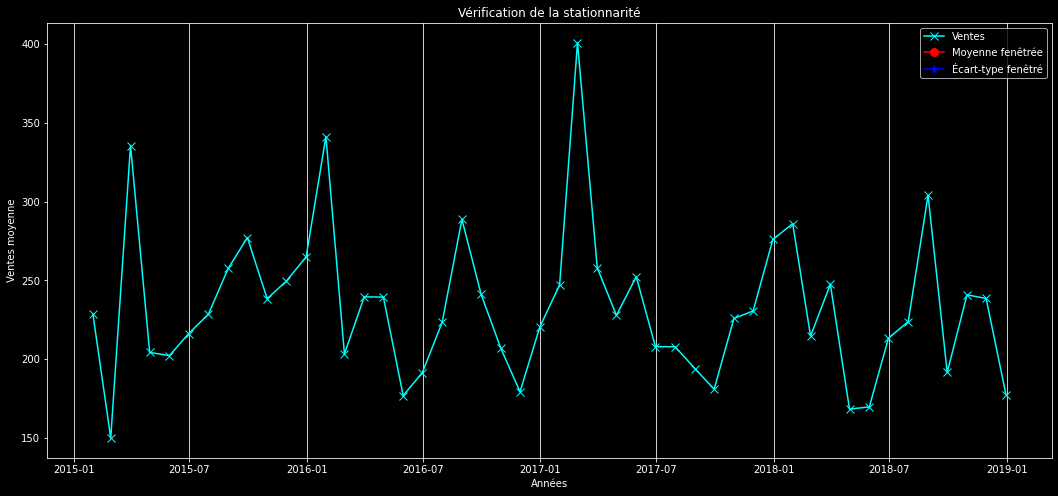

In [59]:
fig,ax = plt.subplots(figsize = (18,8))
ax.plot(df.Sales,marker = 'x',markersize = 8 , label = 'Ventes', color = 'cyan')
ax.plot(sales_mean,marker= 'o', markersize = 8, label = 'Moyenne fenêtrée', color = 'red')
ax.plot(sales_std,marker = '*', markersize = 8, label = 'Écart-type fenêtré',color ='blue')
ax.legend()
plt.xlabel('Années')
plt.ylabel('Ventes moyenne') 
plt.title('Vérification de la stationnarité')
ax.grid(axis = 'x')